# Byte #3: Function Calling with OpenAI (Agents in Action) 🔧

**⏱️ Time to Complete: 10-15 minutes**

Welcome back to hero HQ! By now you can talk to models, reason through async calls, and keep conversations alive. In this byte you will teach an assistant to reach beyond the model and use trusted tools—perfect for building production-ready copilots that can look up data, run calculations, or trigger workflows on demand.

## Why Function Calling?

Models don’t automatically know your private knowledge base, inventory numbers, or the latest sensor readings. Function calling lets you expose safe, well-defined functions so an assistant can fetch facts, perform actions, or orchestrate other systems—all while you stay in control of what can be executed.

### Core Concepts

- **Tool** → A function you register with the model (JSON schema describes inputs).
- **Tool call** → The model requests a tool by name with arguments when it needs external help.
- **Tool result** → Your application executes the function, then replies with the output so the model can finish its answer.
- **Guardrails** → You decide which tools exist and validate every call before running it.

### How Tool Calling Works (Quick View)

1. You describe every tool with JSON Schema so the assistant knows the contract.
2. The model decides whether to call a tool and returns the requested name plus arguments.
3. Your code validates the request, executes the function, and packages the result.
4. You send that tool output back through the `input` list so the model can finish its answer.

_The assistant never runs code on its own—you stay in the loop for every call._

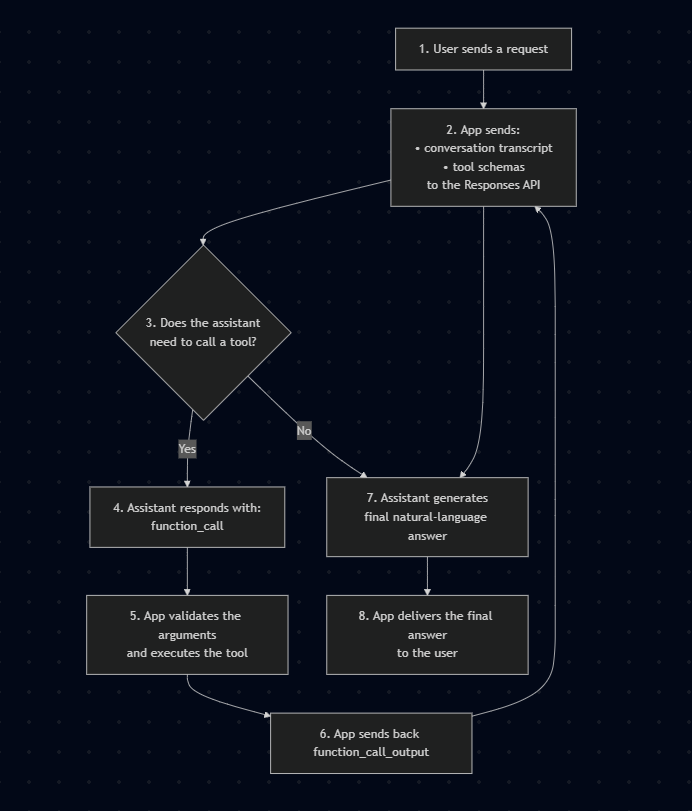

## Setup Checklist

1. Activate your project virtual environment.
2. Install dependencies once with `uv pip install -e .` so the OpenAI SDK and dotenv helper are ready.
3. Confirm your `.env` file has a valid `OPENAI_API_KEY` (and restart the kernel after edits).

In [1]:
from dotenv import load_dotenv
from openai import OpenAI
import json

# Load environment variables so the OpenAI SDK can find OPENAI_API_KEY
load_dotenv()
client = OpenAI()
print("✅ OpenAI client ready for tool calling")

✅ OpenAI client ready for tool calling


## Step 1: Why Use Tools for Math?

Large language models are fluent with words but can drift when arithmetic gets tricky. Asking for the cube root of 343 and the square root of 576 sounds simple, yet minor sampling randomness or a rushed internal calculation can still produce mistakes. Instead of trusting the guess, we can hand the computation to deterministic Python helpers via tool calling and let the model focus on the conversation.

In [2]:
import math

def calculate_root(operation: str, value: float) -> dict:
    """Return precise square or cube roots using Python math helpers."""
    if operation == "square_root":
        result = math.sqrt(value)
    elif operation == "cube_root":
        result = math.copysign(abs(value) ** (1 / 3), value)
    else:
        raise ValueError(f"Unsupported operation: {operation}")
    return {
        "operation": operation,
        "value": value,
        "result": result,
    }

AVAILABLE_TOOLS = {"calculate_root": calculate_root}
print("🛠️ Local tools registered: " + ", ".join(AVAILABLE_TOOLS.keys()))

🛠️ Local tools registered: calculate_root


## Step 2: Describe the Math Tool

The assistant needs a precise contract to know how to call `calculate_root`. We'll publish a JSON Schema that constrains the `operation` to either `square_root` or `cube_root` and requires a numeric `value`.

In [3]:
tools = [
    {
        "type": "function",
        "name": "calculate_root",
        "description": "Compute the square root or cube root of a number using Python math.",
        "parameters": {
            "type": "object",
            "properties": {
                "operation": {
                    "type": "string",
                    "enum": ["square_root", "cube_root"],
                    "description": "Choose whether to calculate a square root or cube root.",
                },
                "value": {
                    "type": "number",
                    "description": "Positive or negative number to process.",
                },
            },
            "required": ["operation", "value"],
        },
    },
 ]
print(json.dumps(tools, indent=2))

[
  {
    "type": "function",
    "name": "calculate_root",
    "description": "Compute the square root or cube root of a number using Python math.",
    "parameters": {
      "type": "object",
      "properties": {
        "operation": {
          "type": "string",
          "enum": [
            "square_root",
            "cube_root"
          ],
          "description": "Choose whether to calculate a square root or cube root."
        },
        "value": {
          "type": "number",
          "description": "Positive or negative number to process."
        }
      },
      "required": [
        "operation",
        "value"
      ]
    }
  }
]


## Step 3: Let the Assistant Delegate the Roots

We'll ask for two values in one sentence: the square root of 576 and the cube root of 343. The model will parse the request, decide to call `calculate_root` for each portion, and we will execute the calculations so the final reply is exact.

In [4]:
question = "Please share the square root of 576 and the cube root of 343."

# Create a running input list we will add to over time
input_list = [
    {
        "role": "user",
        "content": [
            {"type": "input_text", "text": question}
        ],
    }
 ]

# First round-trip: ask the model for help and let it decide if tools are needed
response = client.responses.create(
    model="gpt-5-nano",
    tools=tools,
    input=input_list,
 )
print(response.model_dump_json(indent=2))


{
  "id": "resp_08414dfffd306ff900691e956fda9c819fb21aad0c9a80f208",
  "created_at": 1763612015.0,
  "error": null,
  "incomplete_details": null,
  "instructions": null,
  "metadata": {},
  "model": "gpt-5-nano-2025-08-07",
  "object": "response",
  "output": [
    {
      "id": "rs_08414dfffd306ff900691e95706768819f90fc410a09cb0812",
      "summary": [],
      "type": "reasoning",
      "content": null,
      "encrypted_content": null,
      "status": null
    },
    {
      "id": "msg_08414dfffd306ff900691e95728a7c819f8d26e7b5fcf5dcce",
      "content": [
        {
          "annotations": [],
          "text": "- Square root of 576: 24\n- Cube root of 343: 7",
          "type": "output_text",
          "logprobs": []
        }
      ],
      "role": "assistant",
      "status": "completed",
      "type": "message"
    }
  ],
  "parallel_tool_calls": true,
  "temperature": 1.0,
  "tool_choice": "auto",
  "tools": [
    {
      "name": "calculate_root",
      "parameters": {
        "

### Explanation of the Sample Response

The sample response shows how an LLM decides to use a tool to answer a question.  
In the example, the user asks for the square root of 576 and the cube root of 343.

The model recognizes that these operations match the `calculate_root` tool, which is defined in the response.  
Instead of computing internally, the model prepares tool calls (not shown in the snippet you provided), sends them to the tool, and receives the computed results.

After the tool returns the answers, the model generates the final user-facing message:

- Square root of 576: 24  
- Cube root of 343: 7

This final message is based entirely on the tool’s output.

---

### Response Flow
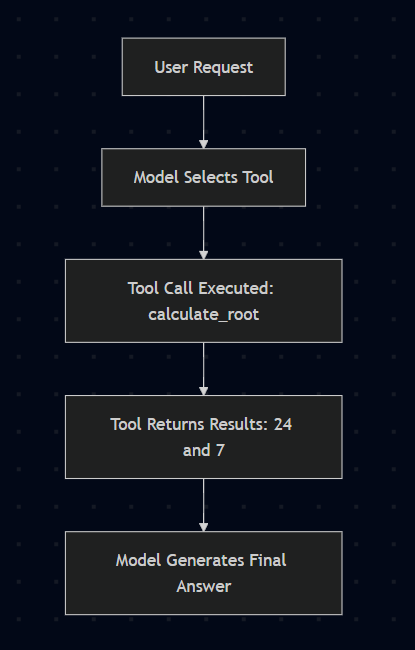

---

### Tool Responses vs. Chat Responses

- **Shape of the payload**: Chat completions return plain text (and maybe function_call metadata), whereas tool responses stream back a list of structured items—text chunks, tool_call requests, and rich objects you can feed right back to the API.
- **Control loop**: In chat mode, you send a prompt and read a reply. In tool mode, you maintain a transcript, inspect each `function_call`, execute allowed tools yourself, and append the results before asking for the final answer.
- **Schema enforcement**: Tool calling requires you to register JSON Schemas so the model knows valid arguments; chat completions accept free-form prompts with no contract.
- **Multi-step orchestration**: Tool responses are designed for multi-hop workflows where the assistant can plan, call tools, and continue reasoning. Chat responses generally end after one turn unless you stitch additional prompts manually.

In [5]:
def _serialize_output_item(item):
    """Convert SDK output objects into dictionaries we can send back to the API."""
    payload = json.loads(item.model_dump_json())
    payload.pop("status", None)
    return payload

# Append everything the model just produced (tool calls, thoughts, etc.) back into the transcript
input_list += [_serialize_output_item(item) for item in response.output]

# Execute each tool request locally and push the results to the transcript
for item in response.output:
    if item.type == "function_call" and item.name == "calculate_root":
        args = item.arguments
        if isinstance(args, str):
            args = json.loads(args or "{}")
        elif args is None:
            args = {}
        tool_result = calculate_root(**args)
        input_list.append({
            "type": "function_call_output",
            "call_id": item.call_id,
            "output": json.dumps(tool_result),
        })

print("Final input transcript:")
print(json.dumps(input_list, indent=2))


Final input transcript:
[
  {
    "role": "user",
    "content": [
      {
        "type": "input_text",
        "text": "Please share the square root of 576 and the cube root of 343."
      }
    ]
  },
  {
    "id": "rs_08414dfffd306ff900691e95706768819f90fc410a09cb0812",
    "summary": [],
    "type": "reasoning",
    "content": null,
    "encrypted_content": null
  },
  {
    "id": "msg_08414dfffd306ff900691e95728a7c819f8d26e7b5fcf5dcce",
    "content": [
      {
        "annotations": [],
        "text": "- Square root of 576: 24\n- Cube root of 343: 7",
        "type": "output_text",
        "logprobs": []
      }
    ],
    "role": "assistant",
    "type": "message"
  }
]


### Step-by-Step Decision Trace

1. **Tool awareness**: Because the schema lists only `calculate_root`, the model knows that any precise math should go through that function.
2. **Argument extraction**: While generating its first response, the model spots “square root of 576” and “cube root of 343,” mapping them to two calls with `operation` and `value` arguments.
3. **Your execution**: Python evaluates both requests—`math.sqrt(576)` and the signed cube root of 343—returning exact floats.
4. **Final message**: With those outputs stitched into the transcript, the model crafts a natural-language answer that cites the tool data instead of guessing.

In [6]:

# Second round-trip: resend the enriched transcript so the model can compose the final answer
response = client.responses.create(
    model="gpt-5-nano",
    instructions="Summarize the tool outputs with the exact numeric answers.",
    tools=tools,
    input=input_list,
 )

print("Final output:")
print(response.model_dump_json(indent=2))
print("\n" + (response.output_text or ""))

Final output:
{
  "id": "resp_08414dfffd306ff900691e9573cd50819f85ee5aa1a885a068",
  "created_at": 1763612019.0,
  "error": null,
  "incomplete_details": null,
  "instructions": "Summarize the tool outputs with the exact numeric answers.",
  "metadata": {},
  "model": "gpt-5-nano-2025-08-07",
  "object": "response",
  "output": [
    {
      "id": "rs_08414dfffd306ff900691e95749dfc819faf884d59836f983d",
      "summary": [],
      "type": "reasoning",
      "content": null,
      "encrypted_content": null,
      "status": null
    },
    {
      "id": "msg_08414dfffd306ff900691e9574ea5c819f8365bf84221c5765",
      "content": [
        {
          "annotations": [],
          "text": "- Square root of 576: 24\n- Cube root of 343: 7",
          "type": "output_text",
          "logprobs": []
        }
      ],
      "role": "assistant",
      "status": "completed",
      "type": "message"
    }
  ],
  "parallel_tool_calls": true,
  "temperature": 1.0,
  "tool_choice": "auto",
  "tools": [

### Flow Recap

1. **Send** the user request along with the `calculate_root` schema.
2. **Inspect** the assistant output—each `function_call` includes the operation (`square_root` or `cube_root`) plus the numeric value it extracted from the question.
3. **Respond** by running the Python helper and pushing a `function_call_output` back into the transcript.
4. **Read** the assistant’s final narrative, which now quotes the precise results computed in Python.

## Step 4: Wrap It in a Helper

Encapsulate the pattern so services can reuse it. The helper below runs the complete loop and returns both the structured tool outputs and the assistant narration, guaranteeing every root comes from Python instead of a language-model guess.

In [7]:
def _parse_arguments(raw_args):
    if isinstance(raw_args, str):
        raw_args = raw_args or "{}"
        return json.loads(raw_args)
    return raw_args or {}

def _serialize_output_item(item):
    payload = json.loads(item.model_dump_json())
    payload.pop("status", None)
    return payload

def _log_response_metrics(response, label):
    usage = getattr(response, "usage", None)
    token_details = {}
    if usage:
        try:
            token_details = usage.model_dump()
        except AttributeError:
            token_details = usage
    if token_details:
        print(f"[{label}] tokens: {json.dumps(token_details, indent=2)}")
    else:
        print(f"[{label}] tokens: n/a")

def run_assistant(prompt: str, model: str = "gpt-5-nano") -> dict:
    """Run the Responses API tool-calling loop and return structured data."""
    transcript = []
    input_list = [
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": prompt}
            ],
        }
    ]

    initial = client.responses.create(
        model=model,
        tools=tools,
        input=input_list,
    )
    transcript.append(initial)
    _log_response_metrics(initial, "initial")
    input_list += [_serialize_output_item(item) for item in initial.output]

    call_outputs = []
    for item in initial.output:
        if item.type == "function_call":
            tool_fn = AVAILABLE_TOOLS.get(item.name)
            args = _parse_arguments(item.arguments)
            if not tool_fn:
                result_payload = {"success": False, "error": f"Unknown tool: {item.name}"}
            else:
                try:
                    result_payload = tool_fn(**args)
                except TypeError as exc:
                    result_payload = {"success": False, "error": str(exc)}
            serialized_result = json.dumps(result_payload)
            call_outputs.append({
                "call_id": item.call_id,
                "output": serialized_result,
            })
            input_list.append({
                "type": "function_call_output",
                "call_id": item.call_id,
                "output": serialized_result,
            })

    final = client.responses.create(
        model=model,
        tools=tools,
        instructions="Summarize the tool findings clearly for the user.",
        input=input_list,
    )
    transcript.append(final)
    _log_response_metrics(final, "final")

    return {
        "prompt": prompt,
        "input_list": input_list,
        "tool_outputs": call_outputs,
        "assistant_text": final.output_text,
        "responses": transcript,
    }

In [8]:

demo = run_assistant("What are the square root of 1024 and the cube root of 64?")
print("*" * 40)
print("\nAssistant response:")
print(demo["assistant_text"])

[initial] tokens: {
  "input_tokens": 97,
  "input_tokens_details": {
    "cached_tokens": 0
  },
  "output_tokens": 238,
  "output_tokens_details": {
    "reasoning_tokens": 192
  },
  "total_tokens": 335
}
[final] tokens: {
  "input_tokens": 371,
  "input_tokens_details": {
    "cached_tokens": 0
  },
  "output_tokens": 46,
  "output_tokens_details": {
    "reasoning_tokens": 0
  },
  "total_tokens": 417
}
****************************************

Assistant response:
- Square root of 1024: 32 (since 32^2 = 1024)
- Cube root of 64: 4 (since 4^3 = 64)
[final] tokens: {
  "input_tokens": 371,
  "input_tokens_details": {
    "cached_tokens": 0
  },
  "output_tokens": 46,
  "output_tokens_details": {
    "reasoning_tokens": 0
  },
  "total_tokens": 417
}
****************************************

Assistant response:
- Square root of 1024: 32 (since 32^2 = 1024)
- Cube root of 64: 4 (since 4^3 = 64)


## Optional: Async Version

Large agents often run in event loops. The async helper mirrors the same flow but awaits each network hop so you can orchestrate multiple assistants concurrently.

In [9]:
from openai import AsyncOpenAI

async_client = AsyncOpenAI()

async def run_assistant_async(prompt: str, model: str = "gpt-5-nano") -> dict:
    """Async variant that mirrors the cumulative input workflow."""
    transcript = []
    input_list = [
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": prompt}
            ],
        }
    ]

    initial = await async_client.responses.create(
        model=model,
        tools=tools,
        input=input_list,
    )
    transcript.append(initial)
    _log_response_metrics(initial, "initial (async)")
    input_list += [_serialize_output_item(item) for item in initial.output]

    call_outputs = []
    for item in initial.output:
        if item.type == "function_call":
            tool_fn = AVAILABLE_TOOLS.get(item.name)
            if not tool_fn:
                continue
            args = _parse_arguments(item.arguments)
            try:
                result_payload = tool_fn(**args)
            except TypeError as exc:
                result_payload = {"success": False, "error": str(exc)}
            json_payload = json.dumps(result_payload)
            call_outputs.append({
                "call_id": item.call_id,
                "output": json_payload,
            })
            input_list.append({
                "type": "function_call_output",
                "call_id": item.call_id,
                "output": json_payload,
            })

    final = await async_client.responses.create(
        model=model,
        tools=tools,
        instructions="Summarize the tool findings clearly for the user.",
        input=input_list,
    )
    transcript.append(final)
    _log_response_metrics(final, "final (async)")

    return {
        "prompt": prompt,
        "input_list": input_list,
        "tool_outputs": call_outputs,
        "assistant_text": final.output_text,
        "responses": transcript,
    }


In [10]:

async_demo = await run_assistant_async("Calculate the square root of 361 and the cube root of -512.")
print("*" * 40)
print("\nAssistant response:")
print(async_demo["assistant_text"])

[initial (async)] tokens: {
  "input_tokens": 47,
  "input_tokens_details": {
    "cached_tokens": 0
  },
  "output_tokens": 380,
  "output_tokens_details": {
    "reasoning_tokens": 320
  },
  "total_tokens": 427
}
[final (async)] tokens: {
  "input_tokens": 597,
  "input_tokens_details": {
    "cached_tokens": 0
  },
  "output_tokens": 355,
  "output_tokens_details": {
    "reasoning_tokens": 320
  },
  "total_tokens": 952
}
****************************************

Assistant response:
- Square root of 361: 19
- Cube root of -512: -8 (since (-8)^3 = -512)
[final (async)] tokens: {
  "input_tokens": 597,
  "input_tokens_details": {
    "cached_tokens": 0
  },
  "output_tokens": 355,
  "output_tokens_details": {
    "reasoning_tokens": 320
  },
  "total_tokens": 952
}
****************************************

Assistant response:
- Square root of 361: 19
- Cube root of -512: -8 (since (-8)^3 = -512)


## When Custom Tools Aren't Needed

Many workflows already ship in the Responses API. After completing the math walkthrough, scroll to the end of this notebook for the built-in `web_search` demo. It highlights how you can mix and match: rely on turnkey tools like `web_search`, `code_interpreter`, or `file_search` for standard capabilities, and reserve custom functions such as `calculate_root` for domain-specific logic.

## Built-In Tools in Action

You do not need to craft a new function for every capability. The Responses API exposes several built-in tools you can toggle on when deploying assistants. The example below reuses `web_search` to surface the latest quantum-computing headline—no custom Python required aside from recording the result. (Feature availability varies by region, so run this cell to confirm access in your account.)


In [11]:
web_search_demo = client.responses.create(
    model="gpt-4.1-mini",
    tools=[{"type": "web_search"}],
    input=[
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": "Find one headline-worthy quantum computing breakthrough from this month and summarize it.",
                }
            ],
        }
    ],
)
print(web_search_demo.model_dump_json(indent=2))
print("\nSummary:")
print(web_search_demo.output_text or "(No text output)")

{
  "id": "resp_04dd89bd966d6bb900691e9589136c819fb9d0df111257cfeb",
  "created_at": 1763612041.0,
  "error": null,
  "incomplete_details": null,
  "instructions": null,
  "metadata": {},
  "model": "gpt-4.1-mini-2025-04-14",
  "object": "response",
  "output": [
    {
      "id": "ws_04dd89bd966d6bb900691e9589faf8819faa13ab9d450cb7c9",
      "action": {
        "query": "quantum computing breakthrough April 2024",
        "type": "search",
        "sources": null
      },
      "status": "completed",
      "type": "web_search_call"
    },
    {
      "id": "msg_04dd89bd966d6bb900691e958b1adc819fae166d05cf6c4cdd",
      "content": [
        {
          "annotations": [
            {
              "end_index": 916,
              "start_index": 707,
              "title": "IBM unveils two new quantum processors - including one that offers a blueprint for fault-tolerant quantum computing by 2029",
              "type": "url_citation",
              "url": "https://www.livescience.com/tech

## ✅ Key Takeaways

✓ Tool calling bridges model creativity with your live systems.

✓ Built-in tools like `web_search`, `code_interpreter`, and `file_search` give you zero-setup superpowers—mix them with your custom functions for richer assistants.

✓ Always describe tools precisely with JSON Schema so the assistant knows when to use them.

✓ You must execute tool logic yourself—validate inputs, handle errors, and return structured output.

✓ Wrap the request → tool → response loop in helpers to keep production agents tidy.

—

**Great work!** You now have the blueprint for assistants that can reason, fetch, and act with confidence.